# Análise de Causalidade e Estabilidade em Ambiente Multi-Tenant

Este notebook documenta a análise de dados completa, desde a identificação do impacto inicial até a criação de análises de risco avançadas.

**Roteiro da Análise:**
1.  **Carregamento e Inspeção Inicial dos Dados**
2.  **Análise de Impacto: Identificando as "Vítimas"**
3.  **Análise de Causalidade Direcional (Heatmaps)**
4.  **Análise Espectral para Quantificar o "Pânico Sistêmico"**
5.  **Criação do Dataset de Inteligência (`analise_avancada.csv`)**
6.  **Análise de Risco e Priorização: Os "Mais Procurados"**
7.  **Análise Investigativa Profunda: Os "Casos Arquivados"**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define um estilo consistente para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')

# Carrega todos os dataframes
try:
    causality_all_df = pd.read_csv('/home/phil/Projects/k8s-noisy-analysis/outputs/sfi2-paper-analysis/default_experiment/multi_round_analysis/multi_round_causality_all.csv')
    correlation_all_df = pd.read_csv('/home/phil/Projects/k8s-noisy-analysis/outputs/sfi2-paper-analysis/default_experiment/multi_round_analysis/multi_round_correlation_all.csv')
    impact_stats_df = pd.read_csv('/home/phil/Projects/k8s-noisy-analysis/outputs/sfi2-paper-analysis/default_experiment/multi_round_analysis/multi_round_impact_aggregated_stats.csv')
    print("Arquivos iniciais carregados com sucesso!")
except FileNotFoundError as e:
    print(f"Erro ao carregar arquivos: {e}. \\nVerifique se os arquivos CSV estão no mesmo diretório que este notebook.")

Arquivos iniciais carregados com sucesso!


In [23]:
# Dicionário de nomes elegantes para métricas
METRIC_DISPLAY_NAMES = {
    'cpu_usage': 'Uso de CPU (%)',
    'memory_usage': 'Uso de Memória (%)',
    'disk_usage': 'Uso de Disco (%)',
    'network_total_bandwidth': 'Banda Total de Rede (MB/s)',
    'disk_throughput_total': 'Vazão Total de Disco (MB/s)',
    # Adicione outras métricas conforme necessário
}

def get_metric_display_name(metric):
    """Retorna o nome elegante da métrica para exibição."""
    return METRIC_DISPLAY_NAMES.get(metric, metric)

## 1. Análise de Impacto: Identificando as "Vítimas"

Nossa primeira análise busca entender o tamanho do dano. O gráfico abaixo mostra a **mudança percentual média** no desempenho de cada tenant para as diferentes métricas.

As barras negativas representam uma degradação na performance. Foi este gráfico que nos deu a primeira pista de que `tenant-cpu`, `tenant-dsk` e `tenant-mem` sofriam impactos brutais em suas respectivas métricas principais.

Gerando gráfico de Análise de Impacto...


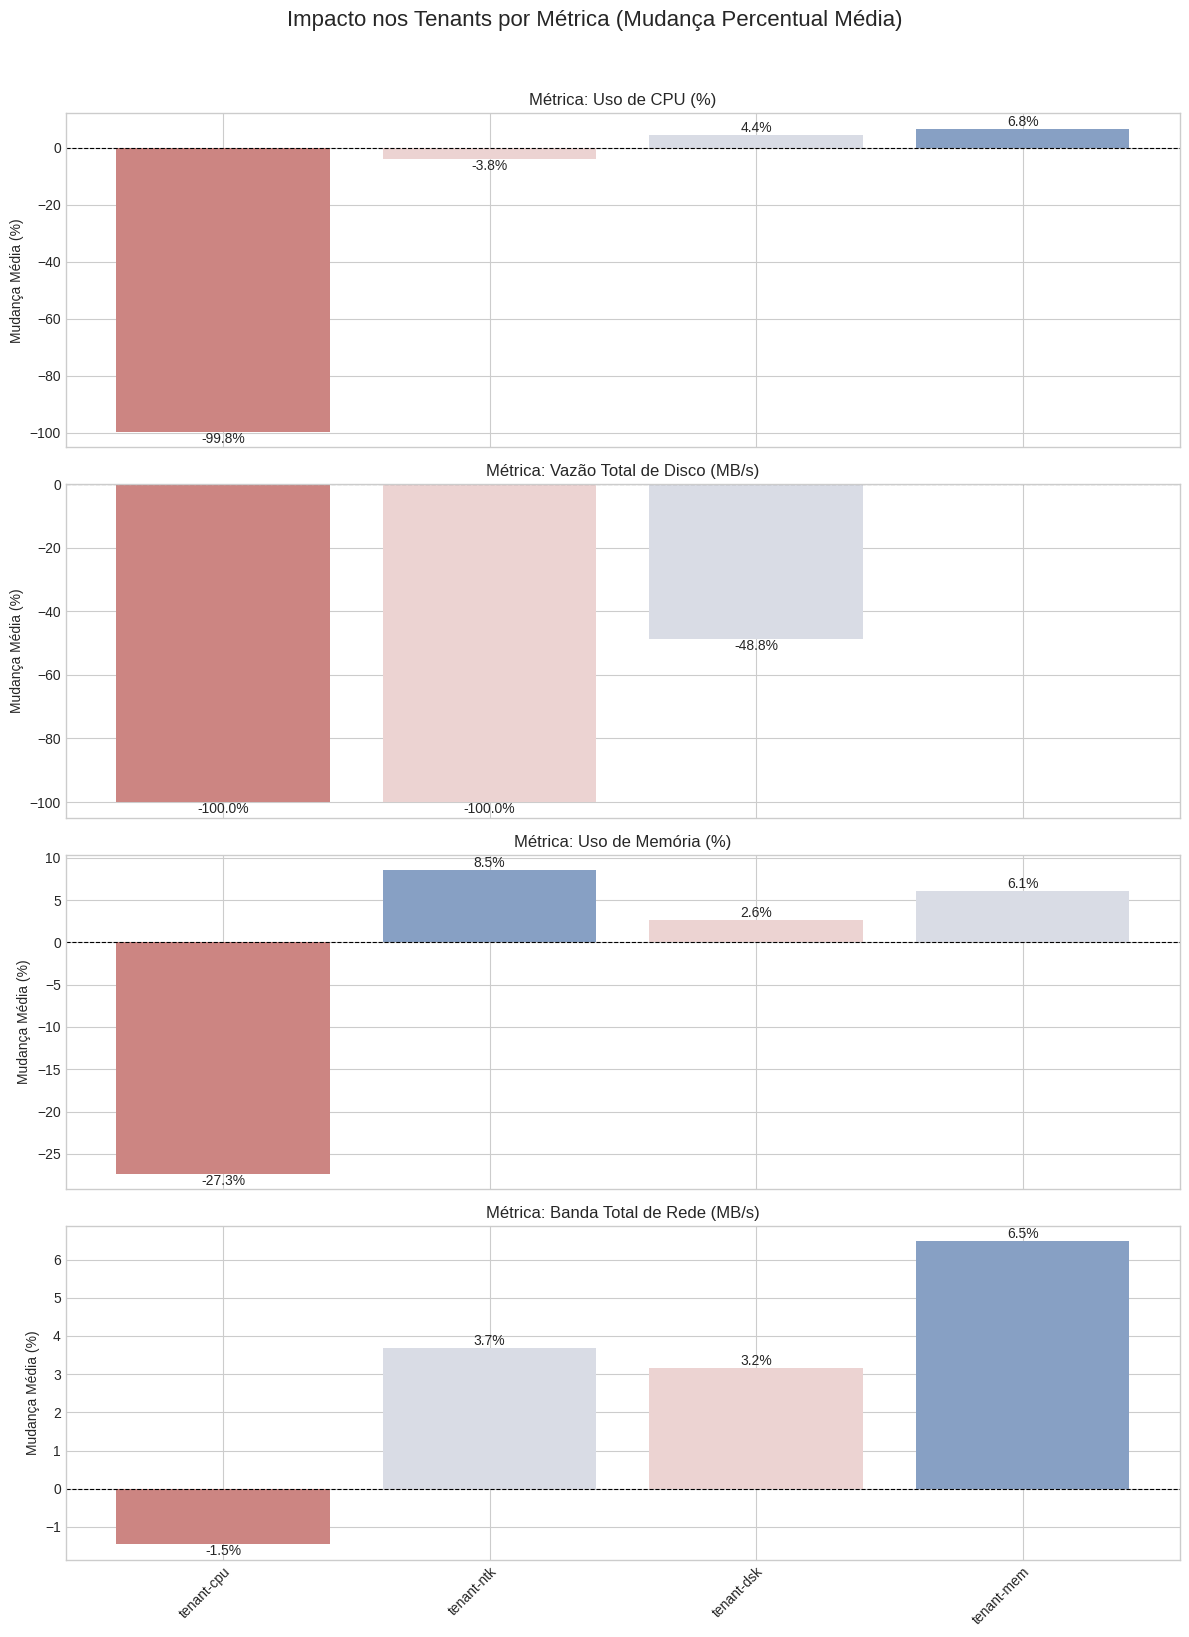

In [25]:
# Gráfico de Barras do Impacto (Mudança Percentual Média)
print("Gerando gráfico de Análise de Impacto...")

fig, axes = plt.subplots(nrows=len(impact_stats_df['metric_name'].unique()), ncols=1, figsize=(12, 16), sharex=True)
fig.suptitle('Impacto nos Tenants por Métrica (Mudança Percentual Média)', fontsize=16, y=1.02)

metrics = impact_stats_df['metric_name'].unique()
for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_df = impact_stats_df[impact_stats_df['metric_name'] == metric].sort_values('mean_percentage_change')
    
    # Usando uma paleta de cores divergente para destacar positivos e negativos
    palette = sns.color_palette("vlag_r", len(metric_df))
    bars = ax.bar(metric_df['tenant_id'], metric_df['mean_percentage_change'], color=palette)
    
    ax.set_ylabel('Mudança Média (%)')
    ax.set_title(f'Métrica: {get_metric_display_name(metric)}')
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Adiciona os rótulos nas barras
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}%', va='bottom' if yval >=0 else 'top', ha='center')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## 2. Análise de Causalidade: Desvendando o Efeito Dominó

A seguir, visualizamos como a interferência se propaga. Usamos heatmaps para mostrar a frequência de links causais significantes (`p-value < 0.05` ou `score` acima do 75º percentil) entre os tenants em cada fase experimental.

**Observação Chave:** O ciclo vicioso entre **Disco (`dsk`) e Memória (`mem`)** é evidente em quase todas as fases, atuando como a principal "avenida" para a propagação do caos.

Gerando Heatmaps de Causalidade Direcional...


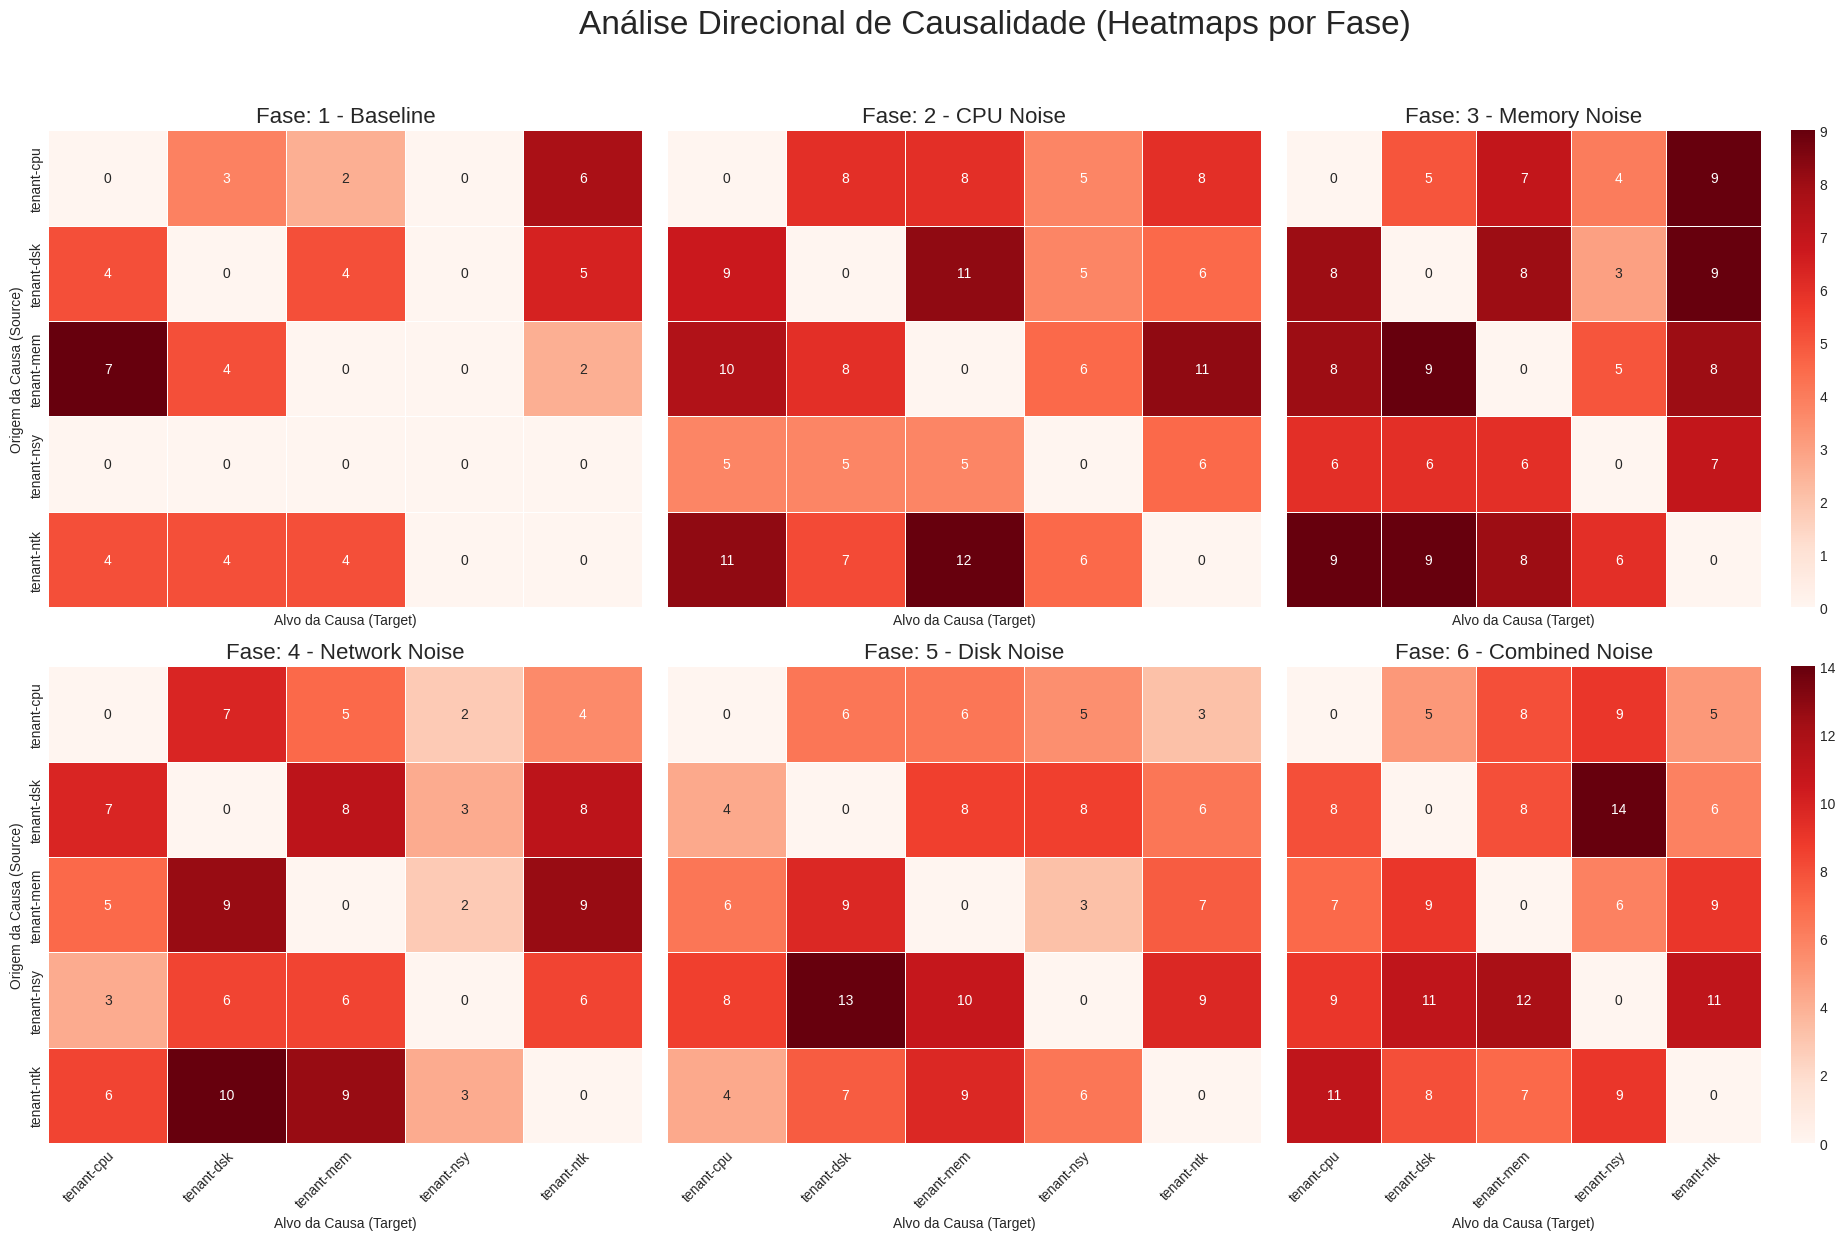

In [26]:
# Análise de Causalidade Direcional (Heatmaps)
print("Gerando Heatmaps de Causalidade Direcional...")

# Define a lógica de significância
score_threshold = causality_all_df['score'].quantile(0.75)
is_significant_pvalue = causality_all_df['p-value'] < 0.05
is_strong_score = causality_all_df['score'] > score_threshold
significant_links = causality_all_df[is_significant_pvalue.fillna(False) | is_strong_score.fillna(False)]

# Configura o plot
phases_to_plot = sorted([p for p in causality_all_df['phase'].unique() if 'Recovery' not in p])
node_order = sorted(list(set(causality_all_df['source']) | set(causality_all_df['target'])))
n_phases = len(phases_to_plot)
n_cols = 3
n_rows = math.ceil(n_phases / n_cols)
fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), sharex=True, sharey=True)
axes1 = axes1.flatten()

for i, phase in enumerate(phases_to_plot):
    ax = axes1[i]
    phase_df = significant_links[significant_links['phase'] == phase]
    edge_counts = phase_df.groupby(['source', 'target']).size().reset_index(name='frequency')
    heatmap_matrix = edge_counts.pivot_table(index='source', columns='target', values='frequency', fill_value=0).reindex(index=node_order, columns=node_order, fill_value=0)
    sns.heatmap(heatmap_matrix, ax=ax, annot=True, fmt='.0f', cmap="Reds", linewidths=.5, cbar=(i == n_cols - 1 or i == n_phases -1))
    ax.set_title(f'Fase: {phase}', size=16)
    ax.set_ylabel('Origem da Causa (Source)' if i % n_cols == 0 else '')
    ax.set_xlabel('Alvo da Causa (Target)')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for j in range(i + 1, len(axes1)):
    axes1[j].set_visible(False)
    
fig1.suptitle('Análise Direcional de Causalidade (Heatmaps por Fase)', fontsize=24, y=1.03)
fig1.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

## 3. Análise Espectral: Onde Mora o Problema?

Para quantificar a instabilidade e provar nossa tese, realizamos uma análise espectral (autovalores) nas matrizes de correlação. O maior autovalor mede o "pânico sistêmico".

Comparamos dois cenários:
1.  **Sistema Completo (5x5):** Incluindo o agente `nsy`.
2.  **Núcleo do Sistema (4x4):** Apenas os tenants essenciais (`cpu`, `dsk`, `mem`, `ntk`).

**Descoberta Definitiva:** O maior nível de pânico ocorre durante o `Disk Noise`. Mais importante, mesmo removendo o `nsy` (barra clara), o pânico nesta fase continua altíssimo. Isso prova que a **fragilidade é inerente ao núcleo do sistema** e não primariamente induzida por um agente externo.

Gerando Análise Comparativa de Autovalores...


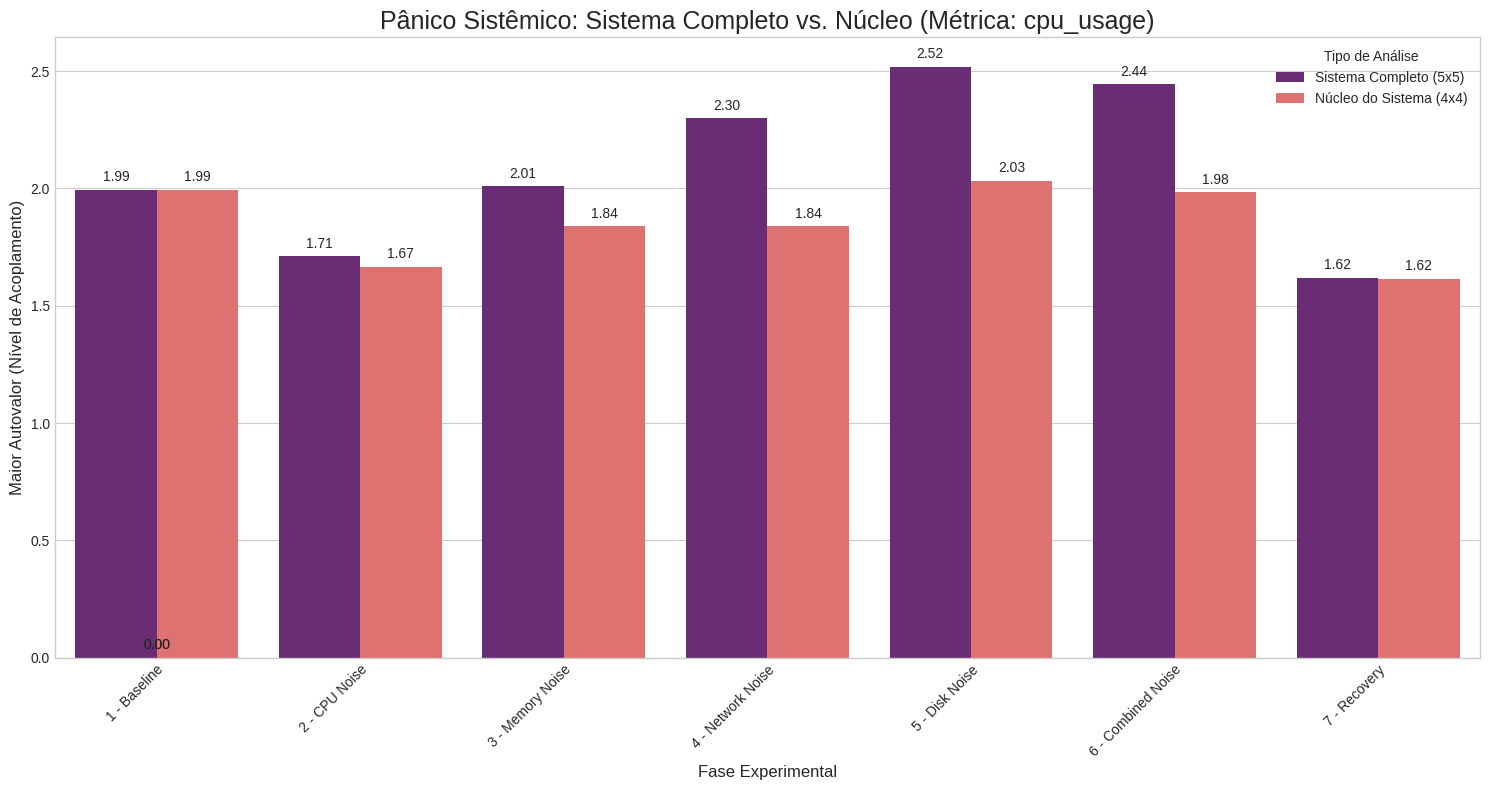

In [28]:
# Análise Comparativa: Sistema Completo vs. Núcleo
print("Gerando Análise Comparativa de Autovalores...")

metric_to_analyze = 'cpu_usage'
metric_corr_df = correlation_all_df[correlation_all_df['metric'] == metric_to_analyze]
all_tenants = sorted(list(set(metric_corr_df['tenant1']) | set(metric_corr_df['tenant2'])))
core_tenants = sorted([t for t in all_tenants if t != 'tenant-nsy'])
phases = sorted(metric_corr_df['phase'].unique())
results = []

for phase in phases:
    phase_df = metric_corr_df[metric_corr_df['phase'] == phase]
    
    # Sistema Completo (5x5)
    corr_matrix_full = pd.DataFrame(np.eye(len(all_tenants)), index=all_tenants, columns=all_tenants)
    for _, row in phase_df.iterrows():
        t1, t2, corr_value = row['tenant1'], row['tenant2'], row['mean_correlation']
        if t1 in all_tenants and t2 in all_tenants:
            corr_matrix_full.loc[t1, t2] = corr_matrix_full.loc[t2, t1] = corr_value
    eigenvalues_full = np.linalg.eigvalsh(corr_matrix_full)
    results.append({'Phase': phase, 'System Type': 'Sistema Completo (5x5)', 'Largest Eigenvalue': eigenvalues_full[-1]})
    
    # Núcleo do Sistema (4x4)
    corr_matrix_core = pd.DataFrame(np.eye(len(core_tenants)), index=core_tenants, columns=core_tenants)
    for _, row in phase_df.iterrows():
        t1, t2, corr_value = row['tenant1'], row['tenant2'], row['mean_correlation']
        if t1 in core_tenants and t2 in core_tenants:
            corr_matrix_core.loc[t1, t2] = corr_matrix_core.loc[t2, t1] = corr_value
    eigenvalues_core = np.linalg.eigvalsh(corr_matrix_core)
    results.append({'Phase': phase, 'System Type': 'Núcleo do Sistema (4x4)', 'Largest Eigenvalue': eigenvalues_core[-1]})

results_df = pd.DataFrame(results)
fig2, ax2 = plt.subplots(figsize=(15, 8))
sns.barplot(x='Phase', y='Largest Eigenvalue', hue='System Type', data=results_df, palette='magma')
ax2.set_title(f'Pânico Sistêmico: Sistema Completo vs. Núcleo (Métrica: {metric_to_analyze})', fontsize=18)
ax2.set_xlabel('Fase Experimental', fontsize=12)
ax2.set_ylabel('Maior Autovalor (Nível de Acoplamento)', fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax2.legend(title='Tipo de Análise')

for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

fig2.tight_layout()
plt.show()

## 5. Criação do Dataset de Inteligência

Para permitir análises mais profundas, vamos consolidar todas as nossas informações em um único CSV mestre, o `analise_avancada.csv`. Este arquivo enriquecerá cada link causal com dados de correlação e impacto, servindo de base para as investigações a seguir.

In [ ]:
# Código para criar o analise_avancada.csv (exatamente como antes)
try:
    print("Construindo o dataset avançado...")

    # 1. Agrega informações de causalidade
    score_threshold = causality_all_df['score'].quantile(0.75)
    causality_all_df['is_significant'] = ((causality_all_df['p-value'] < 0.05) | (causality_all_df['score'] > score_threshold)).fillna(False)
    causality_agg = causality_all_df.groupby(['phase', 'metric', 'source', 'target']).agg(
        mean_p_value=('p-value', 'mean'),
        mean_score=('score', 'mean'),
        significant_frequency=('is_significant', 'sum')
    ).reset_index()

    # 2. Prepara dados de correlação
    correlation_all_df['tenant_pair'] = correlation_all_df.apply(lambda r: '-'.join(sorted([r['tenant1'], r['tenant2']])), axis=1)
    causality_agg['tenant_pair'] = causality_agg.apply(lambda r: '-'.join(sorted([r['source'], r['target']])), axis=1)
    correlation_all_df.rename(columns={'metric_name': 'metric'}, inplace=True)
    
    # 3. Prepara dados de impacto
    impact_source_df = impact_stats_df.rename(columns={'tenant_id': 'source', 'metric_name': 'metric', 'mean_cohen_d': 'source_mean_cohen_d', 'mean_percentage_change': 'source_mean_percentage_change'})
    impact_target_df = impact_stats_df.rename(columns={'tenant_id': 'target', 'metric_name': 'metric', 'mean_cohen_d': 'target_mean_cohen_d', 'mean_percentage_change': 'target_mean_percentage_change'})

    # 4. Faz o merge de tudo
    df_adv = pd.merge(causality_agg, correlation_all_df[['phase', 'metric', 'tenant_pair', 'mean_correlation']], on=['phase', 'metric', 'tenant_pair'], how='left')
    df_adv = pd.merge(df_adv, impact_source_df[['metric', 'source', 'source_mean_percentage_change']], on=['metric', 'source'], how='left')
    df_adv = pd.merge(df_adv, impact_target_df[['metric', 'target', 'target_mean_percentage_change']], on=['metric', 'target'], how='left')
    
    df_adv = df_adv.drop(columns=['tenant_pair']).fillna(0)

    # 5. Salva o novo CSV
    file_name = 'analise_avancada.csv'
    df_adv.to_csv(file_name, index=False)
    
    print(f"Dataset avançado '{file_name}' foi gerado com sucesso.")
    print("\nVisualização do novo dataset:")
    print(df_adv.head())

except Exception as e:
    print(f"Ocorreu um erro ao gerar o arquivo: {e}")

Construindo o dataset avançado...
Dataset avançado 'analise_avancada.csv' foi gerado com sucesso.

Visualização do novo dataset:
          phase     metric      source      target  mean_p_value  mean_score  \
0  1 - Baseline  cpu_usage  tenant-cpu  tenant-dsk      0.170323    0.176874   
1  1 - Baseline  cpu_usage  tenant-cpu  tenant-mem      0.671409    0.081444   
2  1 - Baseline  cpu_usage  tenant-cpu  tenant-ntk      0.287363    0.196141   
3  1 - Baseline  cpu_usage  tenant-dsk  tenant-cpu      0.293814    0.141920   
4  1 - Baseline  cpu_usage  tenant-dsk  tenant-mem      0.001646    0.102709   

   significant_frequency  mean_correlation  source_mean_percentage_change  \
0                      1         -0.268619                     -99.756689   
1                      0         -0.235134                     -99.756689   
2                      1          0.353041                     -99.756689   
3                      1         -0.268619                       4.360521   
4    

## 6. Análise de Risco e Priorização: Os "Mais Procurados"

Agora, usamos o nosso dataset de inteligência para criar um **"Índice de Risco"**. O objetivo é identificar os problemas crônicos: aqueles que são **frequentes E danosos**. Isso nos ajuda a priorizar os esforços de correção nos problemas mais consistentemente perigosos do sistema.

**Fórmula do Risco:** `Frequência * |Correlação| * |Impacto Percentual|`

Executando Análise de Risco para encontrar os 'Mais Procurados'...
\n--- Top 15 Links de Maior Risco Crônico ---
                  phase      source      target     metric  risk_index
300      5 - Disk Noise  tenant-nsy  tenant-cpu  cpu_usage      112.37
376  6 - Combined Noise  tenant-mem  tenant-cpu  cpu_usage      111.16
296      5 - Disk Noise  tenant-mem  tenant-cpu  cpu_usage       90.14
384  6 - Combined Noise  tenant-ntk  tenant-cpu  cpu_usage       87.80
452        7 - Recovery  tenant-dsk  tenant-cpu  cpu_usage       71.84
9          1 - Baseline  tenant-ntk  tenant-cpu  cpu_usage       69.73
380  6 - Combined Noise  tenant-nsy  tenant-cpu  cpu_usage       66.55
136    3 - Memory Noise  tenant-mem  tenant-cpu  cpu_usage       65.43
64        2 - CPU Noise  tenant-ntk  tenant-cpu  cpu_usage       63.95
372  6 - Combined Noise  tenant-dsk  tenant-cpu  cpu_usage       63.42
212   4 - Network Noise  tenant-dsk  tenant-cpu  cpu_usage       62.28
56        2 - CPU Noise  tenant-mem

/tmp/ipykernel_46384/1495423402.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='risk_index', y=top_risks.head(10).apply(lambda r: f"{r['source']} -> {r['target']}\\n({r['phase']})", axis=1), data=top_risks.head(10), palette='Reds_r')


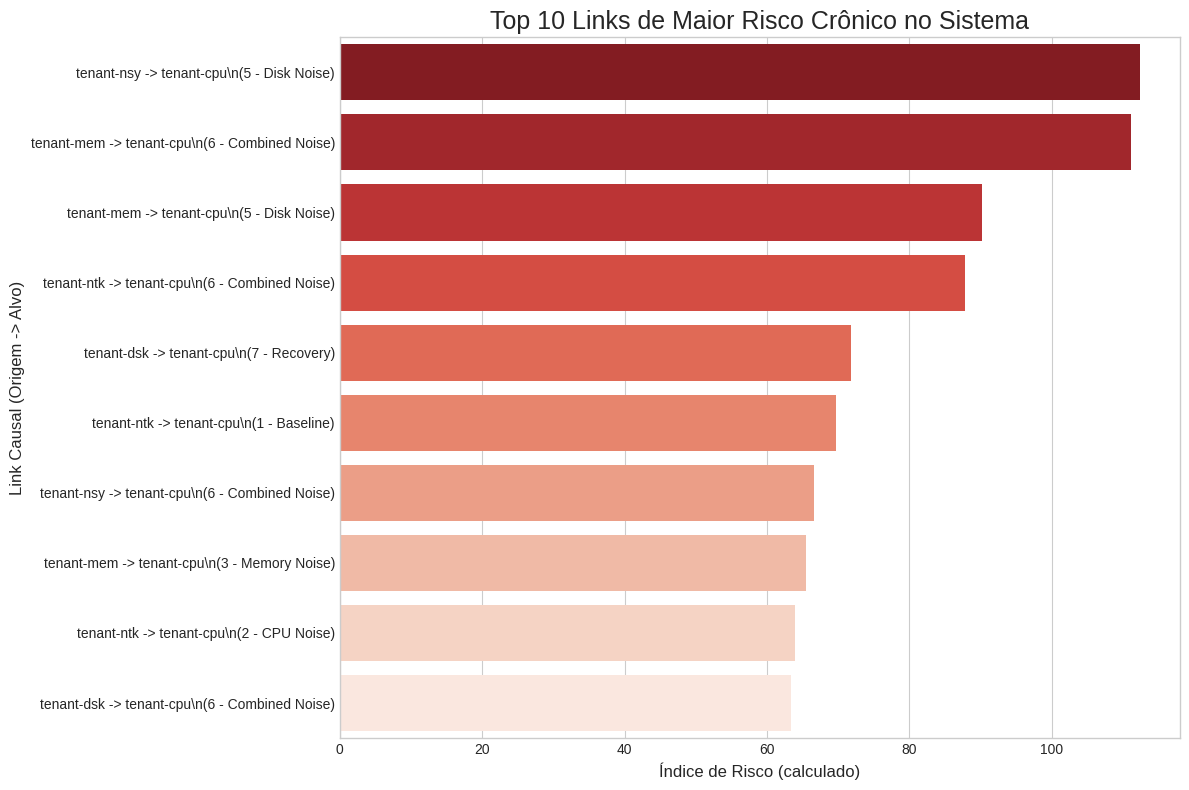

In [ ]:
# Análise de Risco e Priorização
print("Executando Análise de Risco para encontrar os 'Mais Procurados'...")

try:
    df_adv = pd.read_csv('analise_avancada.csv')

    # Calcula o Índice de Risco (evita divisão por zero e usa o valor absoluto do impacto)
    # Adicionamos 1 ao impacto para que impactos de 0% não zerem o risco de links frequentes
    df_adv['risk_index'] = df_adv['significant_frequency'] * abs(df_adv['mean_correlation']) * abs(df_adv['target_mean_percentage_change'] + 1)
    
    # Ordena pelo risco e seleciona as colunas mais importantes
    top_risks = df_adv.sort_values(by='risk_index', ascending=False).head(15)
    
    print("\\n--- Top 15 Links de Maior Risco Crônico ---")
    print(top_risks[['phase', 'source', 'target', 'metric', 'risk_index']].round(2))

    # Visualização dos Top 10
    plt.figure(figsize=(12, 8))
    sns.barplot(x='risk_index', y=top_risks.head(10).apply(lambda r: f"{r['source']} -> {r['target']}\\n({r['phase']})", axis=1), data=top_risks.head(10), palette='Reds_r')
    plt.title('Top 10 Links de Maior Risco Crônico no Sistema', fontsize=18)
    plt.xlabel('Índice de Risco (calculado)', fontsize=12)
    plt.ylabel('Link Causal (Origem -> Alvo)', fontsize=12)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Erro: 'analise_avancada.csv' não encontrado. Execute a célula anterior para gerá-lo.")

## 7. Análise Investigativa Profunda: Os "Casos Arquivados"

Por fim, vamos caçar os "cisnes negros": os **links silenciosos e perigosos**. São interações que ocorrem com **baixa frequência**, mas que, **quando ocorrem, têm um impacto catastrófico**. Eles não apareceriam na lista de risco anterior, mas representam ameaças ocultas que precisamos conhecer.

In [ ]:
# Análise Investigativa Profunda
print("Executando Análise Investigativa para encontrar os 'Casos Arquivados'...")

try:
    df_adv = pd.read_csv('analise_avancada.csv')

    # Define os critérios da investigação
    low_frequency_threshold = 3
    high_impact_threshold = -20 # Impacto de -20%

    # Aplica os filtros
    silent_deadly_links = df_adv[
        (df_adv['significant_frequency'] < low_frequency_threshold) &
        (df_adv['target_mean_percentage_change'] < high_impact_threshold)
    ]

    # Ordena pelo impacto para ver os piores casos primeiro
    result = silent_deadly_links.sort_values(by='target_mean_percentage_change', ascending=True).head(20)
    
    print(f"\\n--- Investigação: Top 20 Links Silenciosos e Perigosos ---")
    print(f"(Frequência < {low_frequency_threshold} | Impacto no Alvo < {high_impact_threshold}%)\\n")
    
    if result.empty:
        print("Nenhum link com essas características exatas foi encontrado.")
    else:
        print(result[['phase', 'metric', 'source', 'target', 'significant_frequency', 'target_mean_percentage_change']].to_string())

except FileNotFoundError:
    print("Erro: 'analise_avancada.csv' não encontrado. Execute a célula anterior para gerá-lo.")

Executando Análise Investigativa para encontrar os 'Casos Arquivados'...
\n--- Investigação: Top 20 Links Silenciosos e Perigosos ---
(Frequência < 3 | Impacto no Alvo < -20%)\n
                 phase                 metric      source      target  significant_frequency  target_mean_percentage_change
18        1 - Baseline  disk_throughput_total  tenant-mem  tenant-cpu                      0                         -100.0
17        1 - Baseline  disk_throughput_total  tenant-dsk  tenant-ntk                      0                         -100.0
15        1 - Baseline  disk_throughput_total  tenant-dsk  tenant-cpu                      0                         -100.0
14        1 - Baseline  disk_throughput_total  tenant-cpu  tenant-ntk                      0                         -100.0
21        1 - Baseline  disk_throughput_total  tenant-ntk  tenant-cpu                      0                         -100.0
20        1 - Baseline  disk_throughput_total  tenant-mem  tenant-ntk         

Gráfico de bolhas da Análise Investigativa Profunda foi gerado e salvo como 'investigative_bubble_chart.png'.


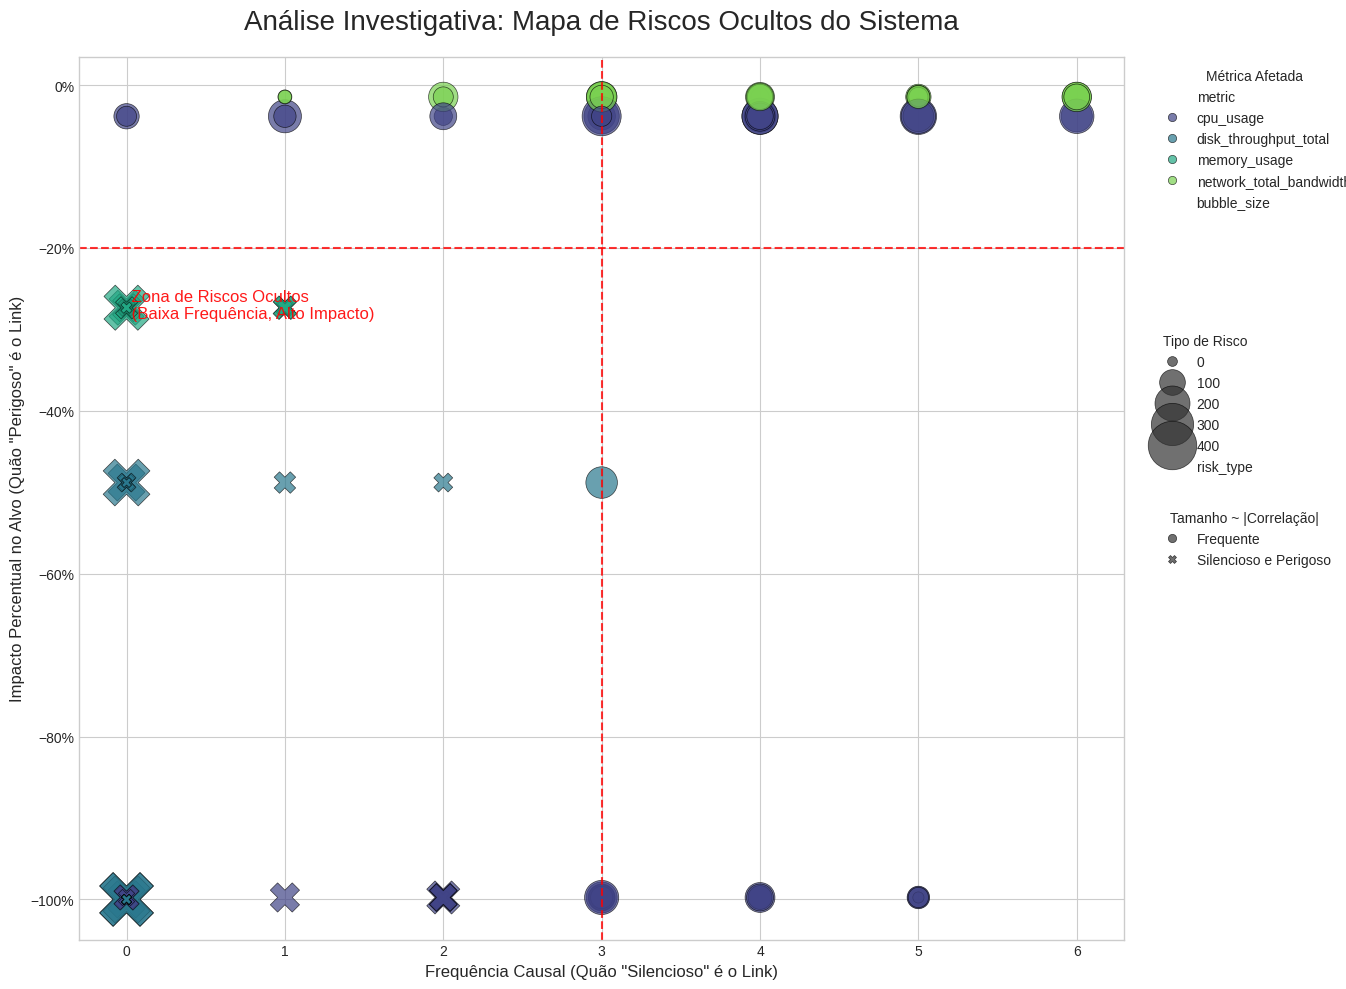

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

try:
    # Load the advanced analysis dataset
    df_adv = pd.read_csv('analise_avancada.csv')

    # We will plot all links, but highlight the "silent and deadly" ones.
    # For the visualization, let's consider all links with negative impact.
    df_plot = df_adv[df_adv['target_mean_percentage_change'] < 0].copy()

    # Create a column to categorize the risk type for better annotation
    df_plot['risk_type'] = 'Frequente'
    df_plot.loc[(df_plot['significant_frequency'] < 3) & (df_plot['target_mean_percentage_change'] < -20), 'risk_type'] = 'Silencioso e Perigoso'
    
    # Calculate bubble size based on correlation
    df_plot['bubble_size'] = abs(df_plot['mean_correlation']) * 500  # Scale size for visibility

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 10))

    ax = sns.scatterplot(
        data=df_plot,
        x='significant_frequency',
        y='target_mean_percentage_change',
        hue='metric',
        size='bubble_size',
        sizes=(50, 1500),  # Min and max bubble sizes
        style='risk_type',
        palette='viridis',
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5
    )

    # --- Annotations and Formatting ---
    ax.set_title('Análise Investigativa: Mapa de Riscos Ocultos do Sistema', fontsize=20, pad=20)
    ax.set_xlabel('Frequência Causal (Quão "Silencioso" é o Link)', fontsize=12)
    ax.set_ylabel('Impacto Percentual no Alvo (Quão "Perigoso" é o Link)', fontsize=12)
    
    # Make y-axis labels more readable as percentages
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    
    # Set x-axis to be integer-based
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    # Add reference lines and text to define the "danger zone"
    ax.axhline(-20, ls='--', color='red', alpha=0.8)
    ax.axvline(3, ls='--', color='red', alpha=0.8)
    ax.text(0, -25, ' Zona de Riscos Ocultos\n (Baixa Frequência, Alto Impacto)', 
            color='red', fontsize=12, va='top', alpha=0.9)

    # Adjust legend
    h, l = ax.get_legend_handles_labels()
    # Separate legends for clarity
    legend1 = plt.legend(h[:6], l[:6], bbox_to_anchor=(1.02, 1), loc='upper left', title='Métrica Afetada')
    ax.add_artist(legend1)
    legend2 = plt.legend(h[6:-2], l[6:-2], bbox_to_anchor=(1.02, 0.7), loc='upper left', title='Tipo de Risco')
    ax.add_artist(legend2)
    legend3 = plt.legend(h[-2:], l[-2:], bbox_to_anchor=(1.02, 0.5), loc='upper left', title='Tamanho ~ |Correlação|')


    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for legend
    plt.savefig('investigative_bubble_chart.png', dpi=300)

    print("Gráfico de bolhas da Análise Investigativa Profunda foi gerado e salvo como 'investigative_bubble_chart.png'.")

except FileNotFoundError:
    print("Erro: O arquivo 'analise_avancada.csv' não foi encontrado.")
    print("Por favor, execute o passo anterior que gera este arquivo.")
except Exception as e:
    print(f"Ocorreu um erro durante a análise: {e}")

/tmp/ipykernel_46384/162136990.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Gráfico de barras clássico foi gerado e salvo como 'investigative_barchart_classic.png'.


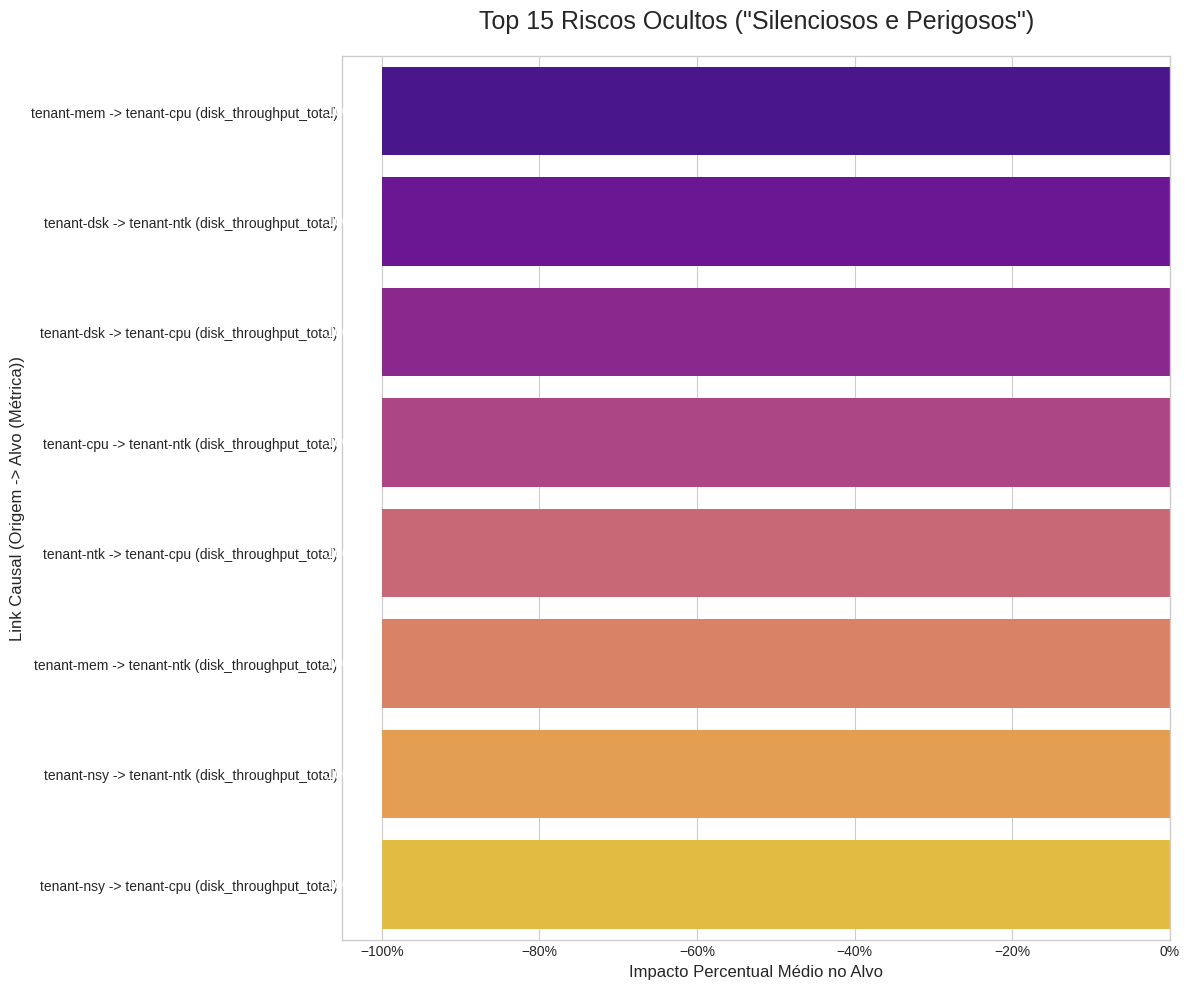

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

try:
    # Load the advanced analysis dataset
    df_adv = pd.read_csv('analise_avancada.csv')

    # Filter for the "silent and deadly" links
    low_frequency_threshold = 3
    high_impact_threshold = -20

    silent_deadly_links = df_adv[
        (df_adv['significant_frequency'] < low_frequency_threshold) &
        (df_adv['target_mean_percentage_change'] < high_impact_threshold)
    ].copy()

    # To make the chart readable, we'll take the top 15 most impactful links
    top_links = silent_deadly_links.sort_values(by='target_mean_percentage_change', ascending=True).head(15)

    # Create a descriptive label for the y-axis
    top_links['link_label'] = top_links.apply(
        lambda row: f"{row['source']} -> {row['target']} ({row['metric']})", 
        axis=1
    )

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10))

    # Create the horizontal bar plot
    ax = sns.barplot(
        x='target_mean_percentage_change',
        y='link_label',
        data=top_links,
        palette='plasma',
        orient='h'
    )

    # --- Annotations and Formatting ---
    ax.set_title(f'Top 15 Riscos Ocultos ("Silenciosos e Perigosos")', fontsize=18, pad=20)
    ax.set_xlabel('Impacto Percentual Médio no Alvo', fontsize=12)
    ax.set_ylabel('Link Causal (Origem -> Alvo (Métrica))', fontsize=12)

    # Format x-axis as percentages
    ax.xaxis.set_major_formatter(mticker.PercentFormatter())
    
    # Add value labels to the end of each bar
    for p in ax.patches:
        width = p.get_width()
        plt.text(width - 1,  # Position the text slightly inside the bar
                 p.get_y() + p.get_height() / 2,
                 f'{width:.1f}%',
                 ha='right',
                 va='center',
                 color='white',
                 weight='bold')
    
    plt.tight_layout()
    plt.savefig('investigative_barchart_classic.png', dpi=300)

    print("Gráfico de barras clássico foi gerado e salvo como 'investigative_barchart_classic.png'.")

except FileNotFoundError:
    print("Erro: O arquivo 'analise_avancada.csv' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro durante a análise: {e}")